In [1]:
%autosave 2
%matplotlib inline

Autosaving every 2 seconds


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
from sklearn.metrics import accuracy_score
import time

In [3]:
from scipy.io import loadmat
df = loadmat('ex4data1.mat')
X, y = df['X'], df['y']
X.shape, y.shape
m, n = X.shape[0], X.shape[1]

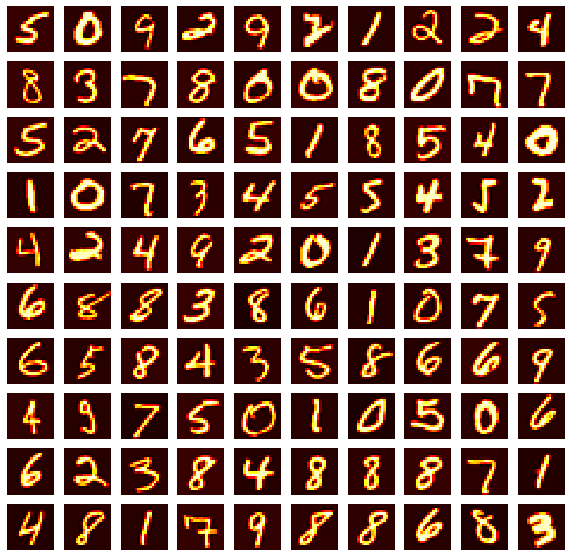

In [4]:
import matplotlib.image as mpimg
fig, axis = plt.subplots(10,10,figsize=(10,10))
for i in range(10):
    for j in range(10):
        axis[i,j].imshow(X[np.random.randint(0,5000),:].reshape(20,20,order="F"), cmap='hot') #reshape back to 20 pixel by 20 pixel
        axis[i,j].axis("off")

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11)
X_train.shape, y_test.shape

((3500, 400), (1500, 1))

As always, we will first build the model using off the shelf library. For this, we will not use the deep learning libraries such as TensorFlow, Keras etc. But rather, we will use sklearn.neural_network

In [6]:
from sklearn.neural_network import MLPClassifier
skmodel = MLPClassifier()
skmodel.fit(X_train, y_train.flatten())

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [7]:
skpred = skmodel.predict(X_test)
skscore = accuracy_score(y_test, skpred)
skscore*100
#with np.printoptions(threshold=np.inf):
#    print(skpred)

93.2

As we can see, 3 lines of code and 30 seconds have resulted in an accuracy score of 100%. WTF bro

Ok, as I expected, the model was kind of overfitting. So, I divided the data into 70/30 split and trained it. After doing this, the accuracy decreased considerably. It decreased so much that now LogisticRegression does better job than this

In [8]:
input_layer_size = 400
hidden_layer_size = 25
output_layer_size = 10

Declaring the number of neurons in the input layer, hidden layer and the output layer

Declaring various different functions for important declarations. Before that, we convert the y into binary vector matrix so that we can train the model easily. 

In [9]:
num_labels = 10
y_bin = np.zeros((5000, 10))
for i in range(m):
    y_bin[i][y[i] % 10] = 1

In [10]:
def sigmoid(z):
    return 1/(1+np.exp(-z))
sigmoid(0)

0.5

In [11]:
def sigmoid_gradient(z):
    return np.multiply(sigmoid(z), (1 - sigmoid(z)))
sigmoid_gradient(0)

0.25

In [12]:
with np.printoptions(threshold=np.inf):
    print(y_bin)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0.

In [13]:
def randomInitialize(l_in, l_out):
    epsilon = (6 ** 0.5)/((l_in + l_out) ** 0.5)
    w = np.random.rand(l_out, l_in+1) * (2 * epsilon) - epsilon
    return w


Randomly Initialize the weights to break the symmetricity problem in the neural networks. 

In [14]:
ini_theta1 = randomInitialize(input_layer_size, hidden_layer_size)
ini_theta2 = randomInitialize(hidden_layer_size, output_layer_size)
ini_param = np.append(ini_theta1.flatten(), ini_theta2.flatten())
ini_param

array([ 0.00688119,  0.00567522, -0.09842354, ..., -0.2014711 ,
        0.116577  ,  0.18454109])

In [15]:
def nncostFunction(nnparam, X, y, input_layer_size, hidden_layer_size, num_lables, reg_param):
    theta1 = nnparam[:((input_layer_size+1) * (hidden_layer_size))].reshape(hidden_layer_size, input_layer_size + 1)
    theta2 = nnparam[((input_layer_size+1) * (hidden_layer_size)):].reshape(num_lables, hidden_layer_size + 1)
    a1 = np.append(np.ones((m, 1)), X, axis=1)
    z2 = a1 @ theta1.T
    a2 = np.append(np.ones((m, 1)), sigmoid(z2), axis=1)
    z3 = a2 @ theta2.T
    a3 = sigmoid(z3)
    J_matrix = ((np.multiply(y_bin, np.log(a3))) + (np.multiply((1 - y_bin), np.log(1 - a3))))
    J = np.sum(J_matrix)
    J = (-1/m) * J
    reg_term = np.sum(theta1[:, 1:] ** 2) + np.sum(theta2[:, 1:] ** 2)
    J_reg = J + ((reg_param / (2*m)) * reg_term)
    return J_reg

In [16]:
def backProp(nnparam, X, y, input_layer_size, hidden_layer_size, num_lables, reg_param):
    theta1 = nnparam[:((input_layer_size+1) * (hidden_layer_size))].reshape(hidden_layer_size, input_layer_size + 1)
    theta2 = nnparam[((input_layer_size+1) * (hidden_layer_size)):].reshape(num_lables, hidden_layer_size + 1)
    a1 = np.append(np.ones((m, 1)), X, axis=1)
    z2 = a1 @ theta1.T
    a2 = np.append(np.ones((m, 1)), sigmoid(z2), axis=1)
    z3 = a2 @ theta2.T
    a3 = sigmoid(z3)
    delta3 = a3 - y_bin
    delta2 = np.multiply((delta3 @ theta2[:, 1:]), sigmoid_gradient(z2))
    grad1 = (delta2.T @ a1)/m
    grad2 = (delta3.T @ a2)/m
    grad1[:, 1:] = grad1[:, 1:] + ((reg_param/m) * theta1[:, 1:])
    grad2[:, 1:] = grad2[:, 1:] + ((reg_param/m) * theta2[:, 1:])
    grad = np.append(grad1.flatten(), grad2.flatten())
    return grad

In [17]:
start_time = time.time()
result = opt.fmin_tnc(func=nncostFunction, x0=ini_param.flatten(), fprime=backProp, args=(X, y_bin, 400, 25, 10, 1))
print(time.time() - start_time)

/home/yash/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/home/yash/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


7.384818077087402


Training the model using the optimization method of fmintnc. It takes some time to train the model, of order 10 seconds. 

In [18]:
all_theta = result[0]
all_theta

array([-3.14546124e-01,  1.51112999e-03, -1.85387971e-02, ...,
       -2.13286948e+00,  2.35611764e+00,  2.11877708e-01])

In [19]:
fin_theta1 = all_theta[:((input_layer_size+1) * (hidden_layer_size))].reshape(hidden_layer_size, input_layer_size + 1)
fin_theta2 = all_theta[((input_layer_size+1) * (hidden_layer_size)):].reshape(num_labels, hidden_layer_size + 1)
fin_theta1.shape , fin_theta2.shape

((25, 401), (10, 26))

In [20]:
X_pred = np.append(np.ones((m, 1)), X, axis=1)
z2 = X_pred @ fin_theta1.T
a2 = np.append(np.ones((m, 1)), sigmoid(z2), axis=1)
z3 = a2 @ fin_theta2.T
a3 = sigmoid(z3)
a3.shape
y_pred = np.argmax(a3, axis=1)

In [21]:
y_pred, y%10

(array([0, 0, 0, ..., 9, 9, 9]),
 array([[0],
        [0],
        [0],
        ...,
        [9],
        [9],
        [9]], dtype=uint8))

In [22]:
accuracy_score(y%10, y_pred)

0.9896

As we can see, we have achieved an accuracy upwards of 95%. That is jusr great!!